In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [2]:
df = pd.read_csv('Effectifs_pooled.csv')
df.head()

,datetime,Réel,Prévision,joursem,isoweek
0,2011-01-03,11127.0,11905.0,0,1
1,2011-01-04,11800.0,12172.0,1,1
2,2011-01-06,11723.0,12363.0,3,1
3,2011-01-07,12320.0,12423.0,4,1
4,2011-01-10,11281.0,11932.0,0,2


In [3]:
df['datetime']=pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431 entries, 0 to 1430
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   datetime   1431 non-null   datetime64[ns]
 1   Réel       1431 non-null   float64       
 2   Prévision  1431 non-null   float64       
 3   joursem    1431 non-null   int64         
 4   isoweek    1431 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 56.0 KB


In [4]:
df['Mois']= df['datetime'].apply( lambda dt1 : dt1.month)
df['An']= df['datetime'].apply( lambda dt1 : dt1.year)
df.head()

,datetime,Réel,Prévision,joursem,isoweek,Mois,An
0,2011-01-03,11127.0,11905.0,0,1,1,2011
1,2011-01-04,11800.0,12172.0,1,1,1,2011
2,2011-01-06,11723.0,12363.0,3,1,1,2011
3,2011-01-07,12320.0,12423.0,4,1,1,2011
4,2011-01-10,11281.0,11932.0,0,2,1,2011


In [11]:
df_calend=pd.read_csv('calendrier_saisons_vacances.csv')
df_calend['datetime']=pd.to_datetime(df_calend['datetime'])
df_calend.drop(columns='Unnamed: 0',inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac
0,2011-01-03,1,False,1,54
1,2011-01-04,1,False,2,53
2,2011-01-06,1,False,4,51
3,2011-01-07,1,False,5,50
4,2011-01-10,1,False,8,47


In [18]:
df_calend1=pd.read_csv('calendrier_fetes_juives.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1=df_calend1[['datetime', 'Fete Juive']]
df_calend1.head()

,datetime,Fete Juive
0,2011-03-21,Pourim
1,2011-04-20,Pessah
2,2011-06-09,Chavouot
3,2011-08-10,Jeûne
4,2011-09-30,Roch


In [20]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['Fete Juive'].fillna('-', inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive
0,2011-01-03,1,False,1,54,NaN
1,2011-01-04,1,False,2,53,NaN
2,2011-01-06,1,False,4,51,NaN
3,2011-01-07,1,False,5,50,NaN
4,2011-01-10,1,False,8,47,NaN


In [22]:
df_calend1=pd.read_csv('calendrier_ramadan.csv')
df_calend1['datetime']=pd.to_datetime(df_calend1['datetime'])
df_calend1.drop(columns='Unnamed: 0',inplace=True)
df_calend1.head()

,ramadan,datetime
0,1,2021-04-13
1,1,2021-04-14
2,1,2021-04-15
3,1,2021-04-16
4,1,2021-04-17


In [23]:
df_calend = pd.merge(df_calend,df_calend1, how='left', on='datetime')
df_calend['ramadan'].fillna(0, inplace=True)
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan
0,2011-01-03,1,False,1,54,-,0.0
1,2011-01-04,1,False,2,53,-,0.0
2,2011-01-06,1,False,4,51,-,0.0
3,2011-01-07,1,False,5,50,-,0.0
4,2011-01-10,1,False,8,47,-,0.0


Maintenant, un peu de feature engineering :

In [24]:
df_calend['DepVac_J']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend['DepVac_S']=df_calend['durée_DepuisVac'].apply(lambda int1 : int1%7 )
df_calend['AvVac_J']=df_calend['durée_AvantVac'].apply(lambda int1 : int1 if int1<=4 else 4 )
df_calend.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,1,False,8,47,-,0.0,4,1,4


In [28]:
df= pd.merge(df,df_calend, how='left', on='datetime')
df.head()

,datetime,Saison,Problème,durée_DepuisVac,durée_AvantVac,Fete Juive,ramadan,DepVac_J,DepVac_S,AvVac_J
0,2011-01-03,1,False,1,54,-,0.0,1,1,4
1,2011-01-04,1,False,2,53,-,0.0,2,2,4
2,2011-01-06,1,False,4,51,-,0.0,4,4,4
3,2011-01-07,1,False,5,50,-,0.0,4,5,4
4,2011-01-10,1,False,8,47,-,0.0,4,1,4


In [100]:
enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']])
enc.fit(df[['An','Mois','joursem', 'DepVac_J', 'ramadan', 'AvVac_J']])
enc.categories_

[array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022], dtype=int64),
 array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12], dtype=int64),
 array([0, 1, 2, 3, 4], dtype=int64),
 array([1, 2, 3, 4], dtype=int64),
 array([0., 1.]),
 array([-3, -2,  1,  2,  3,  4], dtype=int64)]

In [101]:
# X = enc.transform(df[['An','Mois','joursem', 'Fete Juive', 'ramadan', 'DepVac_J', 'DepVac_S', 'AvVac_J']]).toarray()
X = enc.transform(df[['An','Mois','joursem', 'DepVac_J', 'ramadan', 'AvVac_J']]).toarray()
y = df['Réel']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model_fit = model.fit(X_train, y_train)

In [87]:
model_fit.coef_

array([-2.18019357e+15, -2.18019357e+15, -2.18019357e+15, -2.18019357e+15,
       -2.18019357e+15, -2.18019357e+15, -2.18019357e+15, -2.18019357e+15,
       -2.18019357e+15, -2.18019357e+15, -2.18019357e+15, -2.18019357e+15,
        4.31100018e+16,  4.31100018e+16,  4.31100018e+16,  4.31100018e+16,
        4.31100018e+16,  5.76421379e+16,  5.76421379e+16,  5.76421379e+16,
        5.76421379e+16,  5.76421379e+16, -3.52479954e+16, -3.52479954e+16,
       -3.52479954e+16, -3.52479954e+16, -2.29444065e+15, -2.29444065e+15,
       -2.29444065e+15, -2.29444065e+15, -2.29444065e+15, -2.29444065e+15,
       -2.29444065e+15, -1.51896840e+16, -1.51896840e+16, -1.51896840e+16,
       -1.51896840e+16, -1.51896840e+16, -1.51896840e+16])

In [88]:
model_fit.intercept_

-4.583982607255346e+16

In [104]:
y_train_pred = model_fit.predict(X_train)
y_test_pred = model_fit.predict(X_test)

In [39]:
from sklearn.metrics import mean_squared_error, r2_score

In [105]:
df_metric = pd.DataFrame( {'MSE': [mean_squared_error(y_train,y_train_pred), mean_squared_error(y_test,y_test_pred)],
                           'r2': [r2_score(y_train,y_train_pred), r2_score(y_test,y_test_pred)]}, index=['Train','Test'] )

df_metric.head()

,MSE,r2
Train,822603.571678,0.659823
Test,992869.226481,0.604699


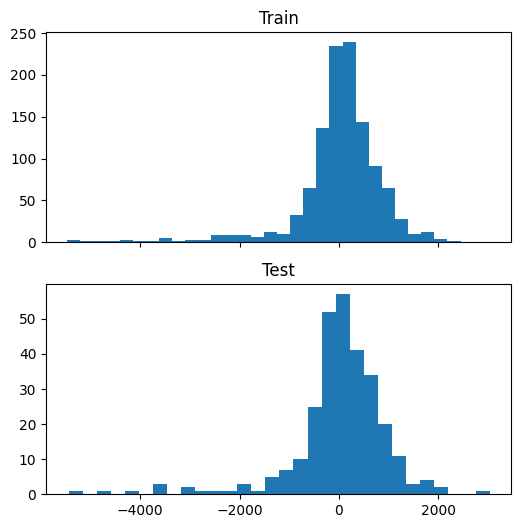

In [98]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6), sharex=True)
ax1.set_title('Train')
ax1.hist(y_train-y_train_pred, bins = 30)
ax2.set_title('Test')
ax2.hist(y_test-y_test_pred, bins = 30)
plt.show()

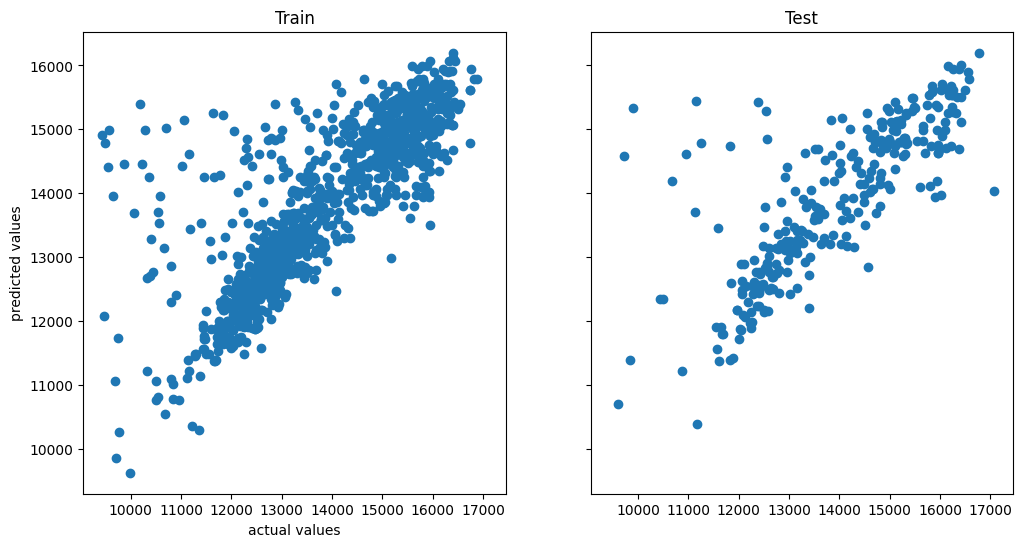

In [99]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
ax1.set_title('Train')
ax1.set_xlabel('actual values')
ax1.set_ylabel('predicted values')
ax1.scatter(x=y_train, y=y_train_pred)
ax2.set_title('Test')
ax2.scatter(x=y_test, y=y_test_pred)
plt.show()